# Artificial Intelligence - Fall 2020 - Laboratory 04 : State-Space Search

c: Alexandra Dobrescu <alexandramaria.digital@gmail.com>

## Introduction

State-space search or pathfinding requires a sequence of actions in the space of states \begin{equation*} s_{0} \mapsto s_{f} \end{equation*} which can be:
* explored, 
* discovered(frontier), 
* unexplored.

**A\*** is the most widespread option for this type of problems in AI: the algorithm finds the shortest path and uses a heuristic to guide itself.

## Today's Challenge

Given a bidimensional map with various obstacles, find the shortest path between two positions within it.

_Note:_ The **labyrinth** variable will play the role of the bidimensional map.

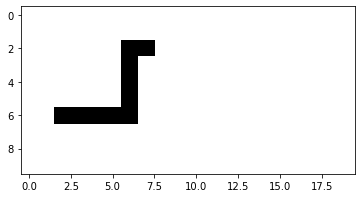

In [1]:
# Dimensions of the map.
height = 10
width = 20

# Bidimensional map as a list of lists.
# The empty cells are marked with 0, while blocks of walls with 1.
labyrinth = [[0 for c in range(width)] for r in range(height)]

for r in range(2, 7):
    labyrinth[r][6] = 1
    labyrinth[6][r] = 1
labyrinth[2][7] = 1

# Display labyrinth
%matplotlib inline
import matplotlib.pyplot as pyplot
pyplot.imshow(labyrinth, cmap='Greys', interpolation='nearest');

## Advanced functions

To simplify the iteration process, we can use: 

* `lambda`, the anonymous function which always returns an expression and has the following syntax:

```python
    lambda arguments: expression
```

In [ ]:
# For this problem, we want to find the path 
# from the start point

start = (5, 5)

# to the end point.
final = (8, 8)

# Let us verify if having a list of tuples,
# their position corresponds to the endpoint.

# First, the lambda function:
is_final = lambda position: position == final

Lambda plays the role of an input argument in other functions, such as:

* `map`, which passes each element of the given iterable to a function:

```python
    map(function, iterable)
```

In [3]:
# Second, the map function:
list(map(is_final, [(1,1), (3, 6), (8, 8)]))

[False, False, True]

* `filter` can easily select the values from a sequence with a certain property:

```python
    filter(function, sequence)
```

In [4]:
list(filter(is_final, [(1,1), (3, 6), (8, 8)]))

[(8, 8)]

## The A* algorithm

With the help of the following tasks, create the building blocks of the algorithm.

### Task 0

**a.** Given a certain position represented by a `tuple`, find if its location is valid.

While exploring the bidirectional map, be careful to:

* check if the available coordinates are inside the plane (0-height, 0-width),
* verify if the position is free and not occupied by an obstacle.

In [9]:
def verify_location(position):
    # extract coordinates
    (x, y) = position
    
    if x>=0 and x<height and y>=0 and y<width and labyrinth[x][y]==0:
        return True
    
    return False

In [10]:
list(map(verify_location, [(-1,2), (height,3), (width,4), (5,5), (6,6), (0,9)])) 
# expected answer: [False, False, False, True, False, True]

[False, False, False, True, False, True]

**b.** Once you have verified the position, return its empty neighbours in a `list`.

Use both `filter` function and `verifiy_location` written above.

In [14]:
def get_neighbours(position):
    
    (x,y) = position
    if x>=0 and x<height and y>=0 and y<width:
        return list(filter(verify_location, [(x+1,y+1), (x, y+1), (x+1, y), (x-1, y-1), (x-1, y), (x, y-1), (x+1, y-1), (x-1, y+1)]))
    
    return False

In [15]:
[get_neighbours(p) for p in [(0,9), (5,5)]]
# expected answer: [[(1, 10), (0, 10), (1, 9), (0, 8), (1, 8)], [(4, 4), (4, 5), (5, 4)]]

[[(1, 10), (0, 10), (1, 9), (0, 8), (1, 8)], [(4, 4), (4, 5), (5, 4)]]

### Heuristic search

After checking the surroundings, we want to expand our frontier towards the goal, rather than searching for all possible directions.

### Task 1

**a.** Compute the _Euclidean distance_:

For two dimensions: 

\begin{equation*}
d(x, y) = \sqrt{(x_{1} - y_{1})^{2} + (x_{2} - y_{2})^{2}}
\end{equation*}

In [16]:
from math import sqrt

In [21]:
def euclidean_distance(x, y):
    distance = sqrt(sum([(xi - yi) ** 2 for xi, yi in zip(x, y)]))
    
    return distance

In [22]:
euclidean_distance((2,3), (4, 7))
# expected answer: 4.47213595499958

4.47213595499958

**b.** Compute the _Manhattan distance_:

For two dimensions: 

\begin{equation*}
d(x, y) = \left | x_{1} - x_{2} \right | +  \left | y_{1} - y_{2} \right |
\end{equation*}

In [23]:
def manhattan_distance(x, y):
    
    distance = 0
    for i in range(len(x)):
        for j in range(i + 1, len(x)):
            distance = distance + (abs(x[i] - y[i]) + abs(x[j] - y[j]))
    return distance

In [24]:
manhattan_distance((2,3), (4,0))
# expected answer: 5

5

To decide which location should be first checked from the _frontier_, we need to verify if the new possible route is better than the best previous one.

In practice, this could be accomplished using a **Priority Queue**. 

In [31]:
from heapq import heappop, heappush

priority_queue = []
heappush(priority_queue, ((1, 2), 'cost_so_far: 2'))
heappush(priority_queue, ((0, 1), 'cost_so_far: 1'))
heappush(priority_queue, ((1, 4), 'cost_so_far: 3'))

print(heappop(priority_queue))
print(heappop(priority_queue))
print(heappop(priority_queue))

((0, 1), 'cost_so_far: 1')
((1, 2), 'cost_so_far: 2')
((1, 4), 'cost_so_far: 3')


The frontier uses a priority queue for expansion and has the following structure: 

`frontier[(discovered_nodes_as_tuple), (estimated_cost, node)]`

Save the discovered nodes in a dictionary:

`d[new_node] = (parent, cost_so_far)`

* The movement between cells costs one unit and represents the `real cost g` which helps in measuring the actual distance.
* The estimated distance to the goal is given by the `heuristic function` defined before.

### Task 2

**a.** Implement **A\*** algorithm which receives as arguments the start node, the final node and the heuristic function.

In [28]:
from heapq import heappop, heappush

In [90]:
def astar(start, end, h):
    # Frontier as list
    frontier = []
    heappush(frontier, (0 + h(start, end), start))
    # Discovered nodes as dictionary
    discovered = {start: (None, 0)}
    #none is the previous node
    #0 is the cost to reach it
    while frontier:
        (hi,nodei) = heappop(frontier)
        choices = get_neighbours(nodei)
        for j in choices:
            if j not in discovered:
                (parent,cost)=discovered[nodei]
                heappush(frontier,(h(nodei,j)+h(j,end),j))
                discovered[j]=(nodei,h(nodei,j))
    cost_map = [[discovered[(r,c)][1] if (r,c) in discovered else 0 for c in range(width)]for r in range(height)]
    pyplot.imshow(cost_map , cmap='Greys', interpolation='nearest');
        
    # Retrieve the path
    path = []
    crt = end
    i=0
    while crt != start:
        (prev, cost) = discovered[crt]
        heappush(path, (i, (prev,crt)))
        crt = prev
        i = i+1
    ordered_path=[]
    i=len(path)-1
    while path:
        heappush(ordered_path,((i,heappop(path)[1])))
        i=i-1
        
    return ordered_path # the path, as list of positions

**b.** Run the algorithm using different heuristics.

(0, ((5, 5), (4, 5)))
(1, ((4, 5), (3, 5)))
(2, ((3, 5), (2, 5)))
(3, ((2, 5), (1, 6)))
(4, ((1, 6), (1, 7)))
(5, ((1, 7), (2, 8)))
(6, ((2, 8), (3, 8)))
(7, ((3, 8), (4, 8)))
(8, ((4, 8), (5, 8)))
(9, ((5, 8), (6, 8)))
(10, ((6, 8), (7, 8)))
(11, ((7, 8), (8, 8)))


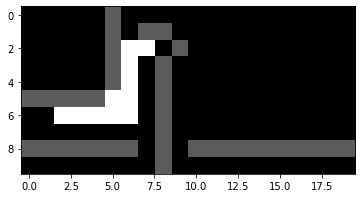

In [92]:
path=astar(start, final, euclidean_distance)
while path:
    print(heappop(path))

(0, ((5, 5), (4, 5)))
(1, ((4, 5), (3, 5)))
(2, ((3, 5), (2, 5)))
(3, ((2, 5), (1, 6)))
(4, ((1, 6), (1, 7)))
(5, ((1, 7), (2, 8)))
(6, ((2, 8), (3, 8)))
(7, ((3, 8), (4, 8)))
(8, ((4, 8), (5, 8)))
(9, ((5, 8), (6, 8)))
(10, ((6, 8), (7, 8)))
(11, ((7, 8), (8, 8)))


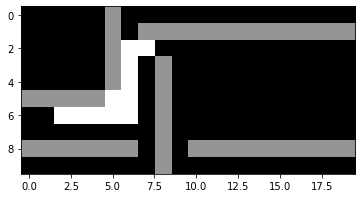

In [93]:
path=astar(start, final, manhattan_distance)
while path:
    print(heappop(path))

**c.** Plot the cost map of this adventure:

```python
cost_map = [[discovered[(r,c)][1] if (r,c) in discovered else 0 for c in range(width)]for r in range(height)]
pyplot.imshow(cost_map , cmap='Greys', interpolation='nearest');
```

### Task 3

* Which heuristic function can be used in our problem, when we can move diagonally on the map?
* Which is the best one to use?
* What if we could only move in the 4 cardinal directions?

*euclidean_distance
*It depends whether you are allowed to move diagonally or not.
*manhattan_distance

In [94]:
feedback = "I found the lab quite hard to solve. I'm not sure why my pyplots look so awkward XD."
print(feedback)

I found the lab quite hard to solve. I'm not sure why my pyplots look so awkward XD.
